In [11]:
#Importing libraries and  data 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


In [12]:
import nbimporter

import pandas as pd
import numpy as np 
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc 
directory = '/Users/adambrowne/Desktop/Personal /LOI Project/Data/events'
jsonfiles = []
for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))


### The event data for the training model is taken from "https://springernature.figshare.com/articles/dataset/Metadata_record_for_A_public_data_set_of_spatio-temporal_match_events_in_soccer_competitions/9711164" ###
### Code for this model was heavily inspired by iandragulets repository "https://github.com/iandragulet/xG_Model_Workflow". It includes a great exploration into the reasoning behind using xG and the statistical accuracy of the model. I highly recommend reading it. ###

In [13]:
#This function will iterate through all shot values in our 'events' dataset and calculate the distance from goal and angle from goal
def shot_matrix(eventdata, encoding = 'utf-8'):
    with open(eventdata, encoding=encoding, errors='replace') as f:
        

        data = json.load(f)

    #Create a dataframe to store the data + attributes we are interested in 
    all_data = []
    #Have to filter passes, tackles etc from data to obtain relevant info 
    event_df = pd.DataFrame(data)
    all_shots = event_df[event_df['subEventName']=='Shot']
    shots_dataset = pd.DataFrame(all_shots)

    #Now fill in attribute columns
    #filter though the all shots dataframe
    for index,shot in all_shots.iterrows():
         shots_dataset.at[index,'Goal']=0
         shots_dataset.at[index, 'header']=0
         for tag in shot['tags']:
             if tag['id']==101:
                 shots_dataset.at[index,'Goal']=1
             elif tag['id']==403:
                 shots_dataset.at[index,'header']=1
    #Now have to index shot distance and angle to goal
    #x and y represent percentage of proximity to top left corner 
    #approximate pitch to be 105mx68m
         shots_dataset.at[index,'x']= 100 - shot['positions'][0]['x']
         shots_dataset.at[index,'y']= shot['positions'][0]['y']
         shots_dataset.at[index,'Center_dis']= abs(shot['positions'][0]['y']-50)

         x = shots_dataset.at[index,'x']*1.05
         y = shots_dataset.at[index,'Center_dis']*0.68
         shots_dataset.at[index,'Distance']=np.sqrt(x**2+y**2)

    #For angle: Find angle made between width of the goal and the straight line distance to the shot location
    #Goal width is 7.32m
         width = 7.32
         a = np.sqrt((y-width/2)**2+x**2)
         b = np.sqrt((y+width/2)**2+x**2)
         k = (width**2-a**2-b**2)/(-2*a*b)
         gamma = np.arccos(k)
         if gamma<0:
             gamma = np.pi + gamma
         shots_dataset.at[index,'Angle Radians']=gamma
         shots_dataset.at[index,'Angle Degrees']=gamma*180/np.pi

    #add identifiers for player, team, match 

         shots_dataset.at[index,'playerid']=shot['playerId']
         shots_dataset.at[index,'matchid']=shot['matchId']
         shots_dataset.at[index,'teamid']=shot['teamId']


    return shots_dataset


In [14]:
#storing all calculated values from the shot_matrix function into a seperate dataset
all_leagues = []
for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
df = pd.concat(all_leagues)

/var/folders/sc/6h_r1t3d0p7cg0nc647jq9r00000gn/T/ipykernel_1582/3371417019.py:41: RuntimeWarning: invalid value encountered in arccos
  gamma = np.arccos(k)
/var/folders/sc/6h_r1t3d0p7cg0nc647jq9r00000gn/T/ipykernel_1582/3371417019.py:41: RuntimeWarning: invalid value encountered in arccos
  gamma = np.arccos(k)
/var/folders/sc/6h_r1t3d0p7cg0nc647jq9r00000gn/T/ipykernel_1582/3371417019.py:41: RuntimeWarning: invalid value encountered in arccos
  gamma = np.arccos(k)


In [15]:
#drop null values
df = df.dropna()
df['header']=pd.to_numeric(df['header'])
df['Goal']= pd.to_numeric(df['Goal'])
df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,header,x,y,Center_dis,Distance,Angle Radians,Angle Degrees,playerid,matchid,teamid
213,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",256992,"[{'y': 57, 'x': 94}, {'y': 0, 'x': 0}]",2500686,Shot,3799,1H,605.975493,...,0.0,6.0,57.0,7.0,7.896050,0.755576,43.291300,256992.0,2500686.0,3799.0
302,10,Shot,"[{'id': 403}, {'id': 1214}, {'id': 1802}]",334552,"[{'y': 42, 'x': 83}, {'y': 100, 'x': 100}]",2500686,Shot,3772,1H,859.236394,...,1.0,17.0,42.0,8.0,18.660549,0.372069,21.317963,334552.0,2500686.0,3772.0
498,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",26389,"[{'y': 43, 'x': 96}, {'y': 100, 'x': 100}]",2500686,Shot,3772,1H,1568.104834,...,0.0,4.0,43.0,7.0,6.348039,0.851948,48.813019,26389.0,2500686.0,3772.0
577,10,Shot,"[{'id': 402}, {'id': 1210}, {'id': 1802}]",276920,"[{'y': 21, 'x': 84}, {'y': 100, 'x': 100}]",2500686,Shot,3772,1H,1800.852078,...,0.0,16.0,21.0,29.0,25.905953,0.184838,10.590449,276920.0,2500686.0,3772.0
629,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1203}, {'id'...",366760,"[{'y': 51, 'x': 73}, {'y': 0, 'x': 0}]",2500686,Shot,3799,1H,2009.537139,...,0.0,27.0,51.0,1.0,28.358154,0.256637,14.704224,366760.0,2500686.0,3799.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642945,10,Shot,"[{'id': 401}, {'id': 1212}, {'id': 1802}]",8561,"[{'y': 45, 'x': 72}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,1972.969422,...,0.0,28.0,45.0,5.0,29.595946,0.244517,14.009788,8561.0,2500098.0,1633.0
643023,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",41174,"[{'y': 33, 'x': 86}, {'y': 0, 'x': 0}]",2500098,Shot,1633,2H,2193.887080,...,0.0,14.0,33.0,17.0,18.700898,0.309646,17.741433,41174.0,2500098.0,1633.0
643051,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",7879,"[{'y': 62, 'x': 88}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2377.197700,...,0.0,12.0,62.0,12.0,15.011516,0.410444,23.516712,7879.0,2500098.0,1623.0
643055,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1206}, {'id'...",145692,"[{'y': 38, 'x': 92}, {'y': 100, 'x': 100}]",2500098,Shot,1623,2H,2381.481625,...,0.0,8.0,38.0,12.0,11.710918,0.461143,26.421528,145692.0,2500098.0,1623.0


In [16]:
#split data into test and train set (20% on test set)
#modelling distance predictor
from sklearn import metrics
from sklearn.model_selection import train_test_split
train_dis = df[['Goal','Distance']].copy()
x_train_dis, x_test_dis, y_train_dis, y_test_dis = train_test_split(train_dis.drop('Goal',axis=1), train_dis['Goal'], test_size=0.2, random_state=10)

from sklearn.linear_model import LogisticRegression
lgm_dis = LogisticRegression()
lgm_dis.fit(x_train_dis, y_train_dis)
log_odds = lgm_dis.coef_[0]
print(lgm_dis.coef_, lgm_dis.intercept_)
pd.DataFrame(log_odds, x_train_dis.columns, columns=['coef']).sort_values(by='coef', ascending=False)

[[-0.14571739]] [0.07938877]


,coef
Distance,-0.145717


In [17]:
# we are going to have to use the pipe line function from sklearn to mesh a polynomial function with logisitic regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
df_dis_2 = df[['Goal','Distance']].copy()
x_train_dis_2, x_test_dis_2, y_train_dis_2, y_test_dis_2 = train_test_split(df_dis_2.drop('Goal',axis=1), 
                                                    df_dis_2['Goal'], test_size=0.20, 
                                                    random_state=10)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lgm_dis_2 = LogisticRegression()
lgm_dis_2.fit(x_train_dis_2,y_train_dis_2)
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lgm_dis_2)])
pipe.fit(x_train_dis_2, y_train_dis_2)



print(lgm_dis_2.coef_,lgm_dis_2.intercept_)

[[-0.21600486  0.00206861]] [0.56923693]


/var/folders/sc/6h_r1t3d0p7cg0nc647jq9r00000gn/T/ipykernel_1582/1946723314.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
/var/folders/sc/6h_r1t3d0p7cg0nc647jq9r00000gn/T/ipykernel_1582/1946723314.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype)

<Axes: title={'center': 'Probability of Scoring Based on Distance'}, xlabel='Distance (m)', ylabel='Probabilty of Goal'>

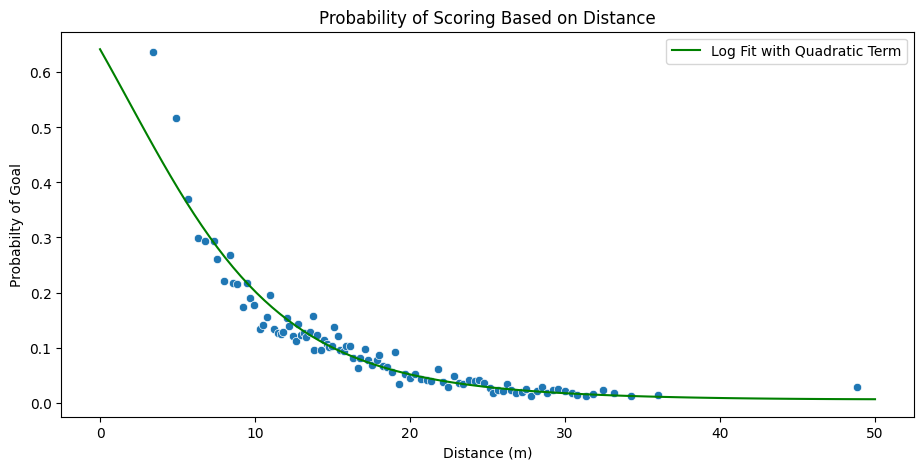

In [18]:
#use the seaborn library to inspect the distribution of the shots by result (goal or no goal) 
fig, axes = plt.subplots(figsize=(11, 5))
#first we want to create bins to calc our probability
#pandas has a function qcut that evenly distibutes the data 
#into n bins based on a desired column value
df['Goal']=df['Goal'].astype(int)
df['Distance_Bins'] = pd.qcut(df['Distance'],q=100)
#now we want to find the mean of the Goal column(our prob density) for each bin
#and the mean of the distance for each bin
dist_prob = df.groupby('Distance_Bins',as_index=False)['Goal'].mean()['Goal']
dist_mean = df.groupby('Distance_Bins',as_index=False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x=dist_mean,y=dist_prob)
dist_trend.set(xlabel="Distance (m)",
       ylabel="Probabilty of Goal",
       title="Probability of Scoring Based on Distance")
dis = np.linspace(0,50,100)
sns.lineplot(x = dis,y = 1/(1+np.exp((0.21632621*dis-0.00206089*dis**2-0.58419379))),color='green',
             label='Log Fit with Quadratic Term')



In [19]:
#similar to before but using ang variable
train_ang = df[['Goal','Angle Degrees']].copy()
x_train_ang, x_test_ang, y_train_ang, y_test_ang = train_test_split(train_ang.drop('Goal',axis=1), 
                                                    train_ang['Goal'], test_size=0.20, 
                                                    random_state=10)

lgm_ang = LogisticRegression()
lgm_ang.fit(x_train_ang,y_train_ang)
log_odds_ang = lgm_ang.coef_[0]
print(lgm_ang.coef_, lgm_ang.intercept_)
pd.DataFrame(log_odds_ang, 
             x_train_ang.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False)

df_poly_ang = df[['Goal','Angle Degrees']].copy()
X_train, X_test, Y_train, Y_test = train_test_split(df_poly_ang.drop('Goal',axis=1), 
                                                    df_poly_ang['Goal'], test_size=0.20, 
                                                    random_state=10)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lr_ang_poly = LogisticRegression()
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lr_ang_poly)])
pipe.fit(X_train, Y_train)

log_odds = lr_ang_poly.coef_[0]


print(lr_ang_poly.coef_,lr_ang_poly.intercept_)

[[0.05261278]] [-3.62838276]
[[ 0.08491393 -0.00035742]] [-4.17642385]


In [20]:
train_2 = df[['Goal','Distance','Angle Radians']].copy()
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(train_2.drop('Goal',axis=1), 
                                                    train_2['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_2 = LogisticRegression(random_state=0)
lgm_2.fit(x_train_2,y_train_2)
log_odds = lgm_2.coef_[0]
print(lgm_2.coef_, lgm_2.intercept_)
print(pd.DataFrame(log_odds, 
             x_train_2.columns, 
             columns=['coef']).sort_values(by='coef', ascending=False))

[[-0.08561002  1.46974931]] [-1.55291198]
                   coef
Angle Radians  1.469749
Distance      -0.085610


In [21]:
#adding whether or not shot type was a header to regression model
train_4 = df[['Goal','Distance','Angle Radians','header']].copy()
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(train_4.drop('Goal',axis=1), 
                                                    train_4['Goal'], test_size=0.20, 
                                                    random_state=10)


lgm_4 = LogisticRegression()
lgm_4.fit(x_train_4,y_train_4)
log_odds = lgm_4.coef_[0]
print(lgm_4.coef_, lgm_4.intercept_)

poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
lr4_poly = LogisticRegression()
pipe = Pipeline([('polynomial_features',poly), ('logistic_regression',lr4_poly)])
pipe.fit(x_train_4, y_train_4)

log_odds = lr4_poly.coef_[0]


print(lr4_poly.coef_,lr4_poly.intercept_)

[[-0.10542262  1.64533422 -1.02289068]] [-1.13418416]
[[-0.2239718   0.11367312 -0.20766953  0.00209827  0.12947388 -0.04717867
   0.30585516 -0.28866537 -0.20766953]] [-0.04234945]


In [27]:
#save model using joblib
import joblib
filename = 'xg_lgm4_model.sav'
joblib.dump(lgm_4, filename=filename)


['xg_lgm4_model.sav']